# Setting and Download

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

######################################
import random

######################################
import os
import zipfile
import glob
#from pathlib import Path

######################################
#from PIL import Image, ImageDraw
import matplotlib.image as mpimg


######################################
#import sklearn


######################################
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop


## Download and extract data

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip 
 

--2021-03-09 14:48:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  85.4MB/s    in 0.8s    

2021-03-09 14:48:01 (85.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
 root_path = os.getcwd()

local_zip = os.path.join(root_path, 'cats_and_dogs_filtered.zip')
with zipfile.ZipFile(local_zip,"r") as zip_ref:
    zip_ref.extractall()

train_validation_dir = os.path.join(root_path, 'cats_and_dogs_filtered')

In [4]:
train_dir = os.path.join(train_validation_dir, 'train')
validation_dir = os.path.join(train_validation_dir, 'validation')

# EDA on the original dataset

In [5]:
all_train_file_paths_pattern = os.path.join(train_dir, '**/*')
all_val_file_paths_pattern = os.path.join(validation_dir, '**/*')

all_train_file_paths = glob.glob(all_train_file_paths_pattern)
all_val_file_paths = glob.glob(all_val_file_paths_pattern)
print("Number of train images:", len(all_train_file_paths))
print("Number of validation images:", len(all_val_file_paths))

Number of train images: 2000
Number of validation images: 1000


In [9]:
cats_dir_train = os.path.join(train_dir, 'cats')
dogs_dir_train = os.path.join(train_dir, 'dogs')

print("In training set:")
print("Number of cat images ", len(os.listdir(cats_dir_train)))
print("Number of dogs images ", len(os.listdir(cats_dir_train)))

In training set:
Number of cat images  1000
Number of dogs images  1000


In [6]:
def show_images_from_directionry_randomly(list_file_paths, n=3):
    fig = plt.gcf() 
    fig.set_size_inches(11,8)
    for i in range(n):
        file_path = random.choice(list_file_paths)
        class_name = file_path.split(os.path.sep)[-2]
        img = mpimg.imread(file_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(class_name)

Some images in the training set:


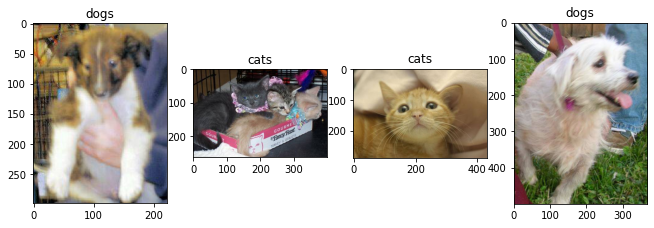

In [13]:
print('Some images in the training set:')
show_images_from_directionry_randomly(all_train_file_paths, 4)

Some images in the validation set:


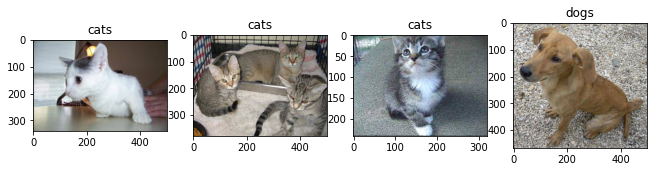

In [14]:
print('Some images in the validation set:')
show_images_from_directionry_randomly(all_val_file_paths, 4)

# Creat the dataset for training: Image Processing with Augmentation

In [17]:
# Method 1: All images will be rescaled by 1./255.
# train_datagen = ImageDataGenerator( rescale = 1.0/255. )
# test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# Method 2: All images will be rescaled by 1./255 and MORE
train_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=40,
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True,
     fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

In [19]:
# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model 1

## Model Architecture

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()


model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

## Training process and History

In [22]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=5,
                              validation_steps=50,
                              verbose=2)

Epoch 1/5
100/100 - 60s - loss: 0.8160 - accuracy: 0.5245 - val_loss: 0.6869 - val_accuracy: 0.5320
Epoch 2/5
100/100 - 58s - loss: 0.7018 - accuracy: 0.5485 - val_loss: 0.6457 - val_accuracy: 0.5880
Epoch 3/5
100/100 - 57s - loss: 0.6775 - accuracy: 0.6025 - val_loss: 0.6111 - val_accuracy: 0.6700
Epoch 4/5
100/100 - 57s - loss: 0.6603 - accuracy: 0.6390 - val_loss: 0.6284 - val_accuracy: 0.6000
Epoch 5/5
100/100 - 57s - loss: 0.6393 - accuracy: 0.6460 - val_loss: 0.6070 - val_accuracy: 0.6510


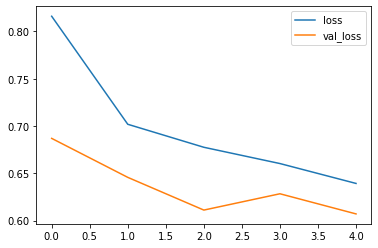

<Figure size 432x288 with 0 Axes>

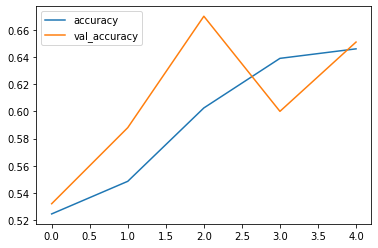

In [23]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.figure()
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()

# Model 2 with transfer learning

## Model architecture 

In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = "imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

87916544/87910968 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 768)


In [29]:

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense (1, activation='sigmoid')(x)           

model2 = tf.keras.Model(pre_trained_model.input, x) 

model2.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])



## Training and history

In [31]:
history = model2.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=5,
                              validation_steps=50,
                              verbose=2)

Epoch 1/5
100/100 - 102s - loss: 0.8748 - accuracy: 0.8285 - val_loss: 0.1023 - val_accuracy: 0.9500
Epoch 2/5
100/100 - 97s - loss: 0.2059 - accuracy: 0.9140 - val_loss: 0.1282 - val_accuracy: 0.9560
Epoch 3/5
100/100 - 96s - loss: 0.1941 - accuracy: 0.9190 - val_loss: 0.1034 - val_accuracy: 0.9640
Epoch 4/5
100/100 - 96s - loss: 0.1773 - accuracy: 0.9235 - val_loss: 0.0981 - val_accuracy: 0.9590
Epoch 5/5
100/100 - 96s - loss: 0.1537 - accuracy: 0.9400 - val_loss: 0.0816 - val_accuracy: 0.9670


In [32]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

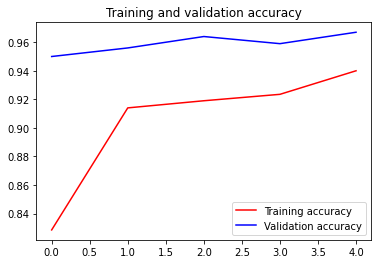

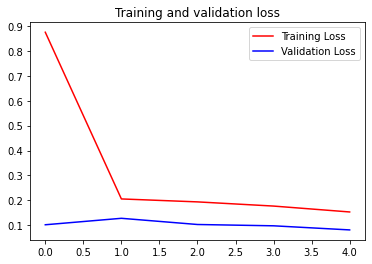

In [33]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()